<a href="https://colab.research.google.com/github/y-lims/DADS7202_Potato/blob/main/Potato_cls_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [10]:
!ls -l /root/.keras/


total 8
-rw-r--r-- 1 root root  120 Jul 29 03:07 keras.json
drwxr-xr-x 2 root root 4096 Jul 29 03:33 models


In [11]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [12]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


# 1. Prepare the environment

## Import Lib

In [13]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras




Python 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]

NumPy 1.25.2

Matplotlib 3.7.1

TensorFlow 2.15.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


In [14]:
import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split


## Set seed

In [15]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np_random_seed = 1
tf_random_seed = 1

np.random.seed(np_random_seed)
tf.random.set_seed(tf_random_seed)

# 2. Load the pretrained model (only the feature extractor)

In [16]:
# Load the ImageNet VGG-16 model, ***excluding*** the classifier
# For VGG-16, the default input_shape is 224x224x3
img_w,img_h = 224,224
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# 3. Prepare our dataset

Mount Drive

In [17]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Dataset

In [18]:

# folder_path = '/content/drive/My Drive/Final_Potato/Dataset/Potato__Healthy/'
# folder_path = '/content/drive/My Drive/Final_Potato/Dataset/Potato__Rotten/'


# folder_path = '/content/drive/My Drive/Final_Potato/Dataset/train/freshpotato'
# folder_path = '/content/drive/My Drive/Final_Potato/Dataset/train/rottenpotato'


# folder_path = '/content/drive/My Drive/Final_Potato/Dataset/test/freshpotato'
# folder_path = '/content/drive/My Drive/Final_Potato/Dataset/test/rottenpotato'


allowed_extensions = (".JPG", ".jpg",".jpeg",".JPEG", ".PNG",".png")
class_mapping = {'healthy': 0, 'rotten': 1}



def process_dataset_nosplit(folder_path, class_name):
    # Initialize an empty list to store the images
    x,y = [], []
    for filename in os.listdir(folder_path):
      # print(filename)
          if filename.endswith(allowed_extensions) :
            # print(filename)
            file_path = os.path.join(folder_path, filename)
            # print(file_path)
            # Load the image and resize to (224, 224)
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
            # Convert PIL Images to NumPy ndarrays
            img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
            # Append the image to the list
            x.append(img_array)

            # Append the numerical label to the list
            y.append(class_mapping[class_name])
    # Convert the list of images to a NumPy array
    x = np.array(x)
    y = np.array(y).reshape(-1,)

    # Display the shape of the resulting array
    # print(f"Shape of x ({class_name}):", x.shape)
    # print(f"Shape of y ({class_name}):", y.shape)
#     return x, y
    return x, y

print('==== Fresh train set ====')
folder_path = '/content/drive/My Drive/Final_Potato/Dataset/train/freshpotato'
x_fr_train, y_fr_train = process_dataset_nosplit(folder_path, 'healthy')
print(f'Shape of x_fr_train: {x_fr_train.shape}')
print(f'Shape of y_fr_train: {y_fr_train.shape}')
print()

print('==== Fresh test set ====')
folder_path = '/content/drive/My Drive/Final_Potato/Dataset/test/freshpotato'
x_fr_test, y_fr_test = process_dataset_nosplit(folder_path, 'healthy')
print(f'Shape of x_fr_test: {x_fr_test.shape}')
print(f'Shape of y_fr_test: {y_fr_test.shape}')
print()

print('==== Rotten train set ====')
folder_path = '/content/drive/My Drive/Final_Potato/Dataset/train/rottenpotato'
x_rot_train, y_rot_train = process_dataset_nosplit(folder_path, 'rotten')
print(f'Shape of x_rot_train: {x_rot_train.shape}')
print(f'Shape of y_rot_train: {y_rot_train.shape}')
print()


print('==== Rotten test set ====')
folder_path = '/content/drive/My Drive/Final_Potato/Dataset/test/rottenpotato'
x_rot_test, y_rot_test = process_dataset_nosplit(folder_path, 'rotten')
print(f'Shape of x_rot_test: {x_rot_test.shape}')
print(f'Shape of y_rot_test: {y_rot_test.shape}')
print()

# ========================== Fruit and Vegetable Disease (Healthy vs Rotten) ========================
print('==== Fruit and Vegetable Disease healthy set ====')
folder_path = '/content/drive/My Drive/Final_Potato/Dataset/Potato__Healthy/'
x_ht, y_ht = process_dataset_nosplit(folder_path, 'healthy')
print(f'Shape of x_ht: {x_ht.shape}')
print(f'Shape of y_ht: {y_ht.shape}')
print()


print('==== Fruit and Vegetable Disease rotten set ====')
folder_path = '/content/drive/My Drive/Final_Potato/Dataset/Potato__Rotten/'
x_rot, y_rot = process_dataset_nosplit(folder_path, 'rotten')
print(f'Shape of x_rot: {x_rot.shape}')
print(f'Shape of y_rot: {y_rot.shape}')
print()



==== Fresh train set ====
Shape of x_fr_train: (536, 224, 224, 3)
Shape of y_fr_train: (536,)

==== Fresh test set ====
Shape of x_fr_test: (270, 224, 224, 3)
Shape of y_fr_test: (270,)

==== Rotten train set ====
Shape of x_rot_train: (812, 224, 224, 3)
Shape of y_rot_train: (812,)

==== Rotten test set ====
Shape of x_rot_test: (370, 224, 224, 3)
Shape of y_rot_test: (370,)

==== Fruit and Vegetable Disease healthy set ====
Shape of x_ht: (600, 224, 224, 3)
Shape of y_ht: (600,)

==== Fruit and Vegetable Disease rotten set ====
Shape of x_rot: (561, 224, 224, 3)
Shape of y_rot: (561,)



Train test split on Fruit and Vegetable Disease (Healthy vs Rotten)

In [20]:
from sklearn.model_selection import train_test_split


# Set a random seed for reproducibility
split_random_seed = 42
np.random.seed(split_random_seed)

# Combine the healthy and rotten datasets
x_disease_combined = np.concatenate((x_ht, x_rot), axis=0)
y_disease_combined = np.concatenate((y_ht, y_rot), axis=0)

# Perform train-test split with stratification and random seed
x_disease_train, x_disease_test, y_disease_train, y_disease_test = train_test_split(x_disease_combined, y_disease_combined, test_size=0.2, stratify=y_disease_combined, random_state=split_random_seed)

print(f'Shape of x_train: {x_disease_train.shape}')
print(f'Shape of y_train: {y_disease_train.shape}')
print(f'Shape of x_test: {x_disease_test.shape}')
print(f'Shape of y_test: {y_disease_test.shape}')


Shape of x_train: (928, 224, 224, 3)
Shape of y_train: (928,)
Shape of x_test: (233, 224, 224, 3)
Shape of y_test: (233,)


Merge all dataset together

In [21]:
x_train = np.concatenate((x_disease_train, x_fr_train, x_rot_train), axis=0)
y_train = np.concatenate((y_disease_train, y_fr_train, y_rot_train), axis=0)

x_test = np.concatenate((x_disease_test, x_fr_test, x_rot_test), axis=0)
y_test = np.concatenate((y_disease_test, y_fr_test, y_rot_test), axis=0)

print('==== Full train set ====')
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print()


print('==== Full test set ====')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

print()
print('==== Total ====')
print("Total images : ",x_train.shape[0] + x_test.shape[0])

==== Full train set ====
Shape of x_train: (2276, 224, 224, 3)
Shape of y_train: (2276,)

==== Full test set ====
Shape of x_test: (873, 224, 224, 3)
Shape of y_test: (873,)

==== Total ====
Total images :  3149


In [22]:
# (x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

# Inspect the dataset
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(2276, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(2276,) , min=0 , max=1
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(873, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(873,) , min=0 , max=1


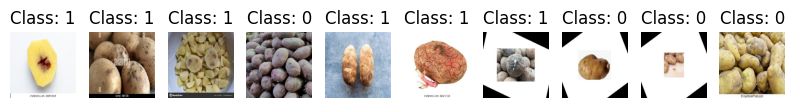

In [23]:
import random
import matplotlib.pyplot as plt

# Set the number of images to display
num_images = 10

# Randomly select indices
random_indices = random.sample(range(len(x_train)), num_images)

# Visualize the randomly selected images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_train[idx].astype('uint8'))
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")
plt.show()


In [24]:
# Preprocess arttoy dataset to match VGG-16's requirements
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

float32 (2276, 224, 224, 3) -123.68 151.061
float32 (873, 224, 224, 3) -123.68 151.061


# Data Augmentation Layer

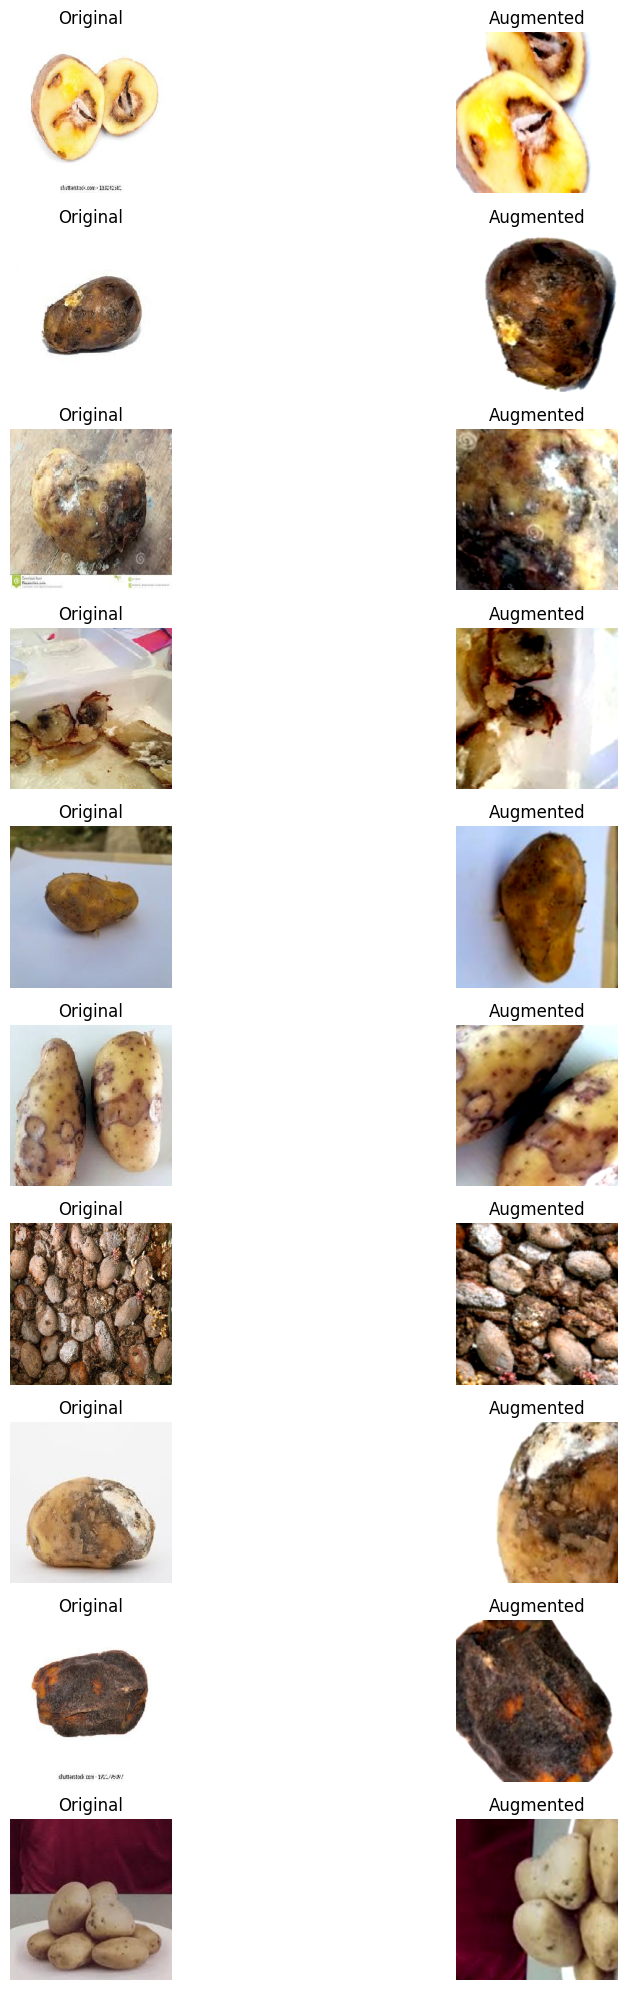

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Create data augmentation pipeline with additional transformations
data_augmentation = tf.keras.Sequential([
    # layers.Rescaling(1./255),
    # layers.RandomFlip("horizontal"),
    # layers.RandomFlip("vertical"),  # Additional flip for vertical flipping
    layers.RandomRotation(0.4),
    layers.RandomZoom(height_factor=(-0.2, -0.5), width_factor=(-0.2, -0.5)),  # Zoom in only
    layers.RandomContrast(0.9),  # Adjust contrast randomly
    # layers.RandomCrop(height=180, width=180),  # Randomly crop to 180x180 from original size
    # layers.CenterCrop(height=150, width=150),  # Center crop to 150x150
])

# ===========================================

# Assume you have image data in x_train
# We will select some images from x_train to show examples
num_examples = 10 # Number of images to display
sample_images = x_train[:num_examples]

# Apply data augmentation to sample images
augmented_images = data_augmentation(sample_images)

# Display original and augmented images in pairs
plt.figure(figsize=(12, 2 * num_examples))
for i in range(num_examples):
    # Original image
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    plt.axis("off")
    plt.title("Original")

    # Augmented image
    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title("Augmented")

plt.tight_layout()
plt.show()


# 4. Prepare for transfer learning and finetuning

1. Add the new classification head
2. Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [26]:
vgg_extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Freeze Layer

In [27]:
# All Layer

vgg_extractor.trainable = False
# Use 'enumerate' to iterate over layers
for i, layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


In [28]:
# Selective Freeze
# Access a layer by its 0-based index
a = vgg_extractor.layers[3]
print( f"Layer {a}: name = {a.name} , trainable = {a.trainable}" )

# # Access a layer by its name
# b = vgg_extractor.get_layer('block5_conv1')
# b.trainable = True       # freeze this layer
# print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

# b = vgg_extractor.get_layer('block5_conv2')
# b.trainable = True       # freeze this layer
# print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

b = vgg_extractor.get_layer('block5_conv3')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )


Layer <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78b024621cf0>: name = block1_pool , trainable = False
Layer <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78aff826ffa0>: name = block5_conv3 , trainable = True


In [29]:
# Iterate over all layers in the model
for i,layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )
vgg_extractor.summary()

Layer 0: name = input_2 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = False
Model: "vgg16"
________________________________________________________

In [30]:
# Create the main model
inputs = tf.keras.Input(shape=(img_w, img_h, 3))
x = data_augmentation(inputs)
x = vgg_extractor(x, training=False)  # Use the extractor with the augmented data


# FC layer
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(2, activation="softmax")(x)  # output layer for 3 classes

model = tf.keras.models.Model(inputs=inputs, outputs=new_outputs)

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026  

In [31]:
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## 4.2 Add a new classification head

In [32]:
vgg_extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation="softmax")(x) # output layer 10 class

# Construct the main model
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## XX 4.3 Data Augmentation XX

In [34]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         #rescale=1. / 255,
#         #featurewise_center=True,
#         #featurewise_std_normalization=True,
#         #zca_whitening=False,
#         samplewise_center=True,
#         samplewise_std_normalization=True,
#         rotation_range=0,
#         width_shift_range=5.0,
#         height_shift_range=5.0,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         # vertical_flip=True,
#         validation_split=0.3)
# train_datagen.fit(x_train_vgg)


In [35]:
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         # rescale=1. / 255,
#         # featurewise_center=True,
#         # featurewise_std_normalization=True,
#         samplewise_center=True,
#         samplewise_std_normalization=True
#         )
# test_datagen.fit(x_test_vgg)

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [ ]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) ,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc']
                     )

history = model.fit(x_train_vgg, y_train,
                    epochs=30,
                    batch_size=32,
                    verbose=2,
                    validation_split=0.2)


Epoch 1/30
57/57 - 46s - loss: 7.7557 - acc: 0.8418 - val_loss: 0.8968 - val_acc: 0.8092 - 46s/epoch - 803ms/step
Epoch 2/30
57/57 - 44s - loss: 0.7313 - acc: 0.9313 - val_loss: 0.3710 - val_acc: 0.9320 - 44s/epoch - 771ms/step
Epoch 3/30
57/57 - 45s - loss: 0.4107 - acc: 0.9451 - val_loss: 0.1925 - val_acc: 0.9539 - 45s/epoch - 786ms/step
Epoch 4/30


## Save model

In [ ]:
model.save(f'/content/drive/My Drive/Final_Potato/l_model/vgg16_v3_{np_random_seed}_{tf_random_seed}.h5')


In [ ]:
from tensorflow.keras.models import load_model

drive.mount('/content/drive')
model_path = f'/content/drive/My Drive/Final_Potato/l_model/vgg16_v3_{np_random_seed}_{tf_random_seed}.h5'
model = load_model(model_path)
model.summary()

In [ ]:
# history = model.fit(
#      x_train_vgg, y_train, batch_size=2, epochs=20, verbose=1, validation_split=0.2
#      )


In [ ]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# 6. Evaluate the model on test set

In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test_vgg, y_test, batch_size=128)
print( f"{model.metrics_names}: {results}" )

# Evaluation

In [ ]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# label = [k for k,v in class_mapping.items()]

# y_pred = []
# for i in range(len(x_test_vgg)):
#   x_input = x_test_vgg[i][np.newaxis, ...]
#   y_pred.append(np.argmax(model.predict(x_input)))
# cm = confusion_matrix(y_test, y_pred)
# ax = sns.heatmap(cm, annot = True, xticklabels = label, yticklabels = label, linewidth=.5, )
# ax.set(xlabel='Predict',ylabel='Actual')

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

# Assuming class_mapping is defined somewhere above
label = [k for k, v in class_mapping.items()]

y_pred = []
for i in range(len(x_test_vgg)):
    x_input = x_test_vgg[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input)))

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')


In [ ]:
# Extracting indices of wrong predictions
incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]
print("Indices of incorrect predictions:", incorrect_indices)


# 7. Inference

In [ ]:
# (Optional) Codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  # Green frame means correct prediction. Red frame means incorrect prediction.
  color = 'blue' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

In [ ]:
# Test using the model on many images

# Get a batch of samples
n = 20
samples = x_test_vgg[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
  plt.figure(figsize=(3,3), dpi=90)
  ax = plt.gca()
  plt.imshow( x_test[i] )
  # plt.title( f"x_test[{i}]: true={y_test[i][0]}({cifar10_labels[y_test[i][0]]}) , pred={np.argmax(y_pred[i])}({cifar10_labels[np.argmax(y_pred[i])]})" )
  color_frame(ax, y_test[i], np.argmax(y_pred[i]))
  plt.show()

# Grad-CAM

In [ ]:
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
last_conv_layer_name = "block5_pool"

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = cmp.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(25):
  c= np.random.randint(0,x_test.shape[0])
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)
